In [1]:
import os
import requests
import json
import warnings
from warnings import filterwarnings
filterwarnings(action="ignore")
from pprint import pprint
import pandas as pd
import statsmodels.tsa.stattools as sts
from scipy.stats.distributions import chi2
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima.model import ARIMAResultsWrapper
from arch import arch_model
import statsmodels.graphics.tsaplots as sgt
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import pmdarima as pm
api_key = os.getenv("API_KEY")
api_base_url = os.getenv("API_BASE_URL")
api_url = f"{api_base_url}={api_key}"
import pickle
load_dotenv()

True

In [2]:
def LLR_test(mod_1, mod_2, df=1):
    L1 = mod_1.fit().llf
    L2= mod_2.fit().llf
    LR = (2*(L2-L1))
    p = chi2.sf(LR, df).round(3)
    return p

### Extract Sample data

In [3]:
filename = "MTN.json"
# with open(filename) as f:
#     data = json.load(f)

# data

### Data Pre-processing

In [4]:
def wrangle(filename):
    with open(filename) as f:
        data = json.load(f)

    # Identifying relevant keys and values for extraction
    # Conversion of data to a DataFrame and transposition to allow for easier manipulation
    df_comp = pd.DataFrame(data["Time Series (Daily)"]).T

    # Conversion of 'Object' types to float
    for i in df_comp.columns:
        df_comp[i] = df_comp[i].astype(float)
    df_comp = df_comp[::-1]

    df_comp.rename(columns= {"4. close":"mkt_price", "1. open":"open", "2. high":"high", "3. low":"low", "5. volume":"volume"}, inplace=True)
    df = df_comp.copy()
    df["dates"] = df.index
    df_comp["dates"] = df_comp.index

    df.dates = pd.to_datetime(df.dates, yearfirst=True)
    df.set_index("dates", inplace=True)
    df = df.asfreq('b')
    df.fillna(method="ffill", inplace=True)

    df_comp.dates = pd.to_datetime(df_comp.dates, yearfirst=True)
    df_comp.set_index("dates", inplace=True)
    df_comp = df_comp.asfreq('b')
    df_comp.fillna(method="ffill", inplace=True)

    df_ = df_comp.copy()

    del df["open"],df["high"],df["low"],df["volume"]

    size = int(0.8 * len(df))
    df_train = df.iloc[:size]
    df_test = df.iloc[size:]

    frames = {"train":df_train, "test":df_test, "copy":df_}

    return frames

    

In [5]:
output = wrangle(filename)

In [6]:
output["copy"]

,open,high,low,mkt_price,volume
dates,,,,,
2024-04-05,5.250,5.37,5.0900,5.290,598250.0
2024-04-08,5.130,5.15,5.0900,5.130,88588.0
2024-04-09,5.040,5.12,5.0000,5.000,36744.0
2024-04-10,5.000,5.00,4.9200,4.920,36685.0
2024-04-11,4.970,5.01,4.9000,4.974,28702.0
...,...,...,...,...,...
2024-08-21,5.035,5.08,5.0050,5.010,3612.0
2024-08-22,5.091,5.10,4.9800,5.022,9686.0
2024-08-23,5.270,5.44,5.2400,5.400,9404.0


In [7]:
df_train = output["train"]

In [8]:
df_train.head()

,mkt_price
dates,
2024-04-05,5.290
2024-04-08,5.130
2024-04-09,5.000
2024-04-10,4.920
2024-04-11,4.974


In [9]:
df_train.tail()

,mkt_price
dates,
2024-07-23,4.2200
2024-07-24,4.1584
2024-07-25,4.2800
2024-07-26,4.2245
2024-07-29,4.1550


In [10]:
df_train.describe()

,mkt_price
count,82.000000
mean,4.608901
std,0.273882
min,4.102000
25%,4.430500
50%,4.577000
75%,4.770000
max,5.290000


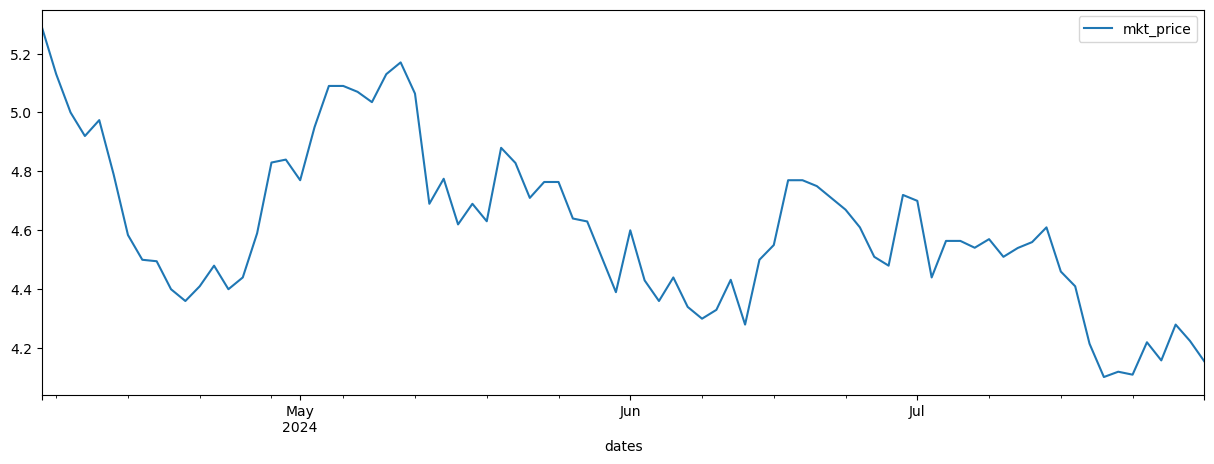

In [11]:
df_train.plot(figsize=(15,5));

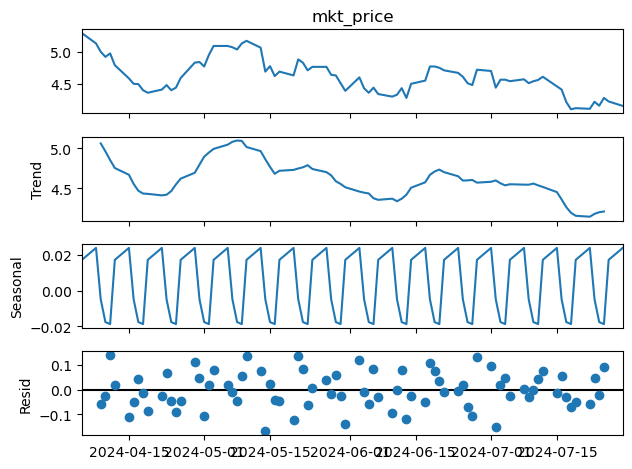

In [12]:
s_dec_additive = seasonal_decompose(df_train.mkt_price, model="additive")
s_dec_additive.plot();

In [13]:
sts.adfuller(df_train.mkt_price)

(-2.4889077544769256,
 0.11819656757514962,
 0,
 81,
 {'1%': -3.5137900174243235,
  '5%': -2.8979433868293945,
  '10%': -2.5861907285474777},
 -95.95501960277258)

###### From the second line of the above output, the series in question is non-stationary. 

##### Computation of returns on prices

In [14]:
df_train["returns"] = df_train.mkt_price.pct_change().mul(100)

In [15]:
sts.adfuller(df_train.returns[1:])

(-9.195930798418186,
 2.0628092351707582e-15,
 0,
 80,
 {'1%': -3.5148692050781247, '5%': -2.8984085156250003, '10%': -2.58643890625},
 326.5430646350761)

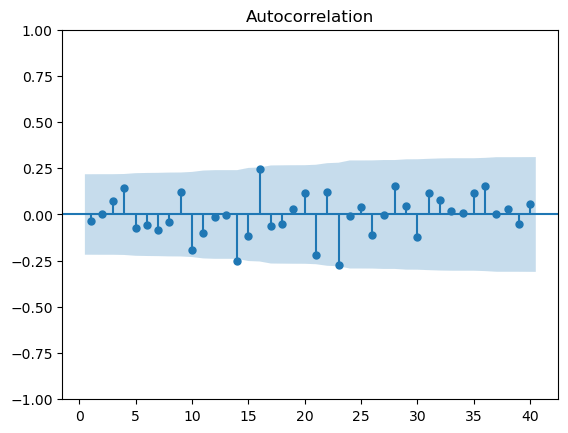

In [16]:
sgt.plot_acf(df_train.returns[1:], lags=40, zero=False);

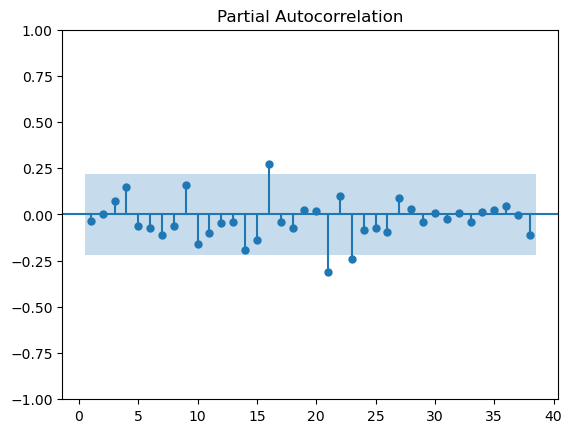

In [17]:
sgt.plot_pacf(df_train.returns[1:], lags=38, zero=False);

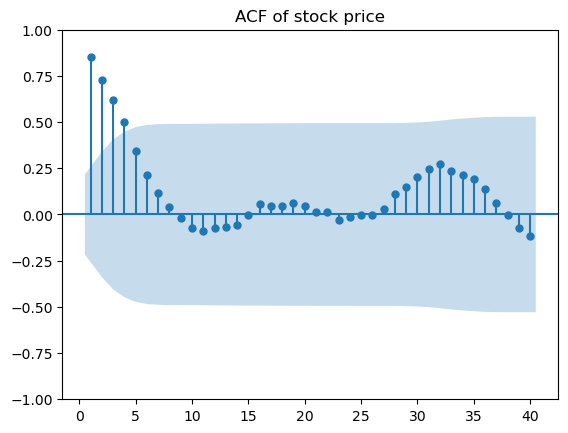

In [18]:
sgt.plot_acf(df_train.mkt_price, lags=40, zero=False)
plt.title("ACF of stock price");

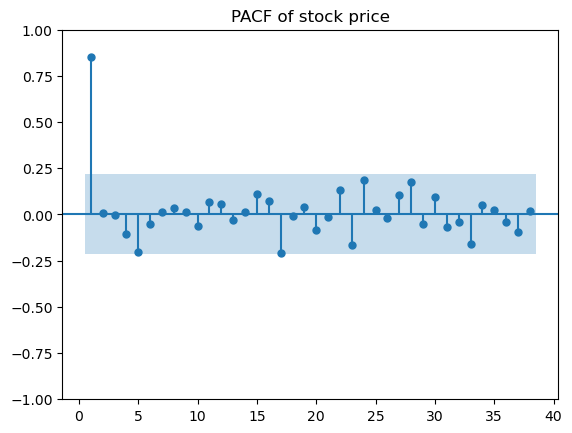

In [19]:
sgt.plot_pacf(df_train.mkt_price, lags=38, zero=False)
plt.title("PACF of stock price");

In [20]:
mod_ma =  ARIMA(df_train.mkt_price, order=(0, 0, 1))
results_ma = mod_ma.fit()
print(results_ma.summary())

                               SARIMAX Results                                
Dep. Variable:              mkt_price   No. Observations:                   82
Model:                 ARIMA(0, 0, 1)   Log Likelihood                  22.343
Date:                Wed, 25 Sep 2024   AIC                            -38.687
Time:                        15:28:01   BIC                            -31.467
Sample:                    04-05-2024   HQIC                           -35.788
                         - 07-29-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.6110      0.037    125.564      0.000       4.539       4.683
ma.L1          0.7360      0.089      8.236      0.000       0.561       0.911
sigma2         0.0336      0.006      5.249      0.0

In [21]:
mod_ma2 =  ARIMA(df_train.mkt_price, order=(0, 0, 2))
results_ma2 = mod_ma2.fit()
print(results_ma2.summary())
print(f"LLR_Test: {LLR_test(mod_ma, mod_ma2)}")

                               SARIMAX Results                                
Dep. Variable:              mkt_price   No. Observations:                   82
Model:                 ARIMA(0, 0, 2)   Log Likelihood                  39.393
Date:                Wed, 25 Sep 2024   AIC                            -70.785
Time:                        15:28:01   BIC                            -61.159
Sample:                    04-05-2024   HQIC                           -66.920
                         - 07-29-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.6106      0.043    107.318      0.000       4.526       4.695
ma.L1          1.0583      0.109      9.696      0.000       0.844       1.272
ma.L2          0.5589      0.090      6.243      0.0

In [22]:
mod_ma3 =  ARIMA(df_train.mkt_price, order=(0, 0, 3))
results_ma3 = mod_ma3.fit()
print(results_ma3.summary())
print(f"LLR_Test: {LLR_test(mod_ma2, mod_ma3)}")

                               SARIMAX Results                                
Dep. Variable:              mkt_price   No. Observations:                   82
Model:                 ARIMA(0, 0, 3)   Log Likelihood                  44.671
Date:                Wed, 25 Sep 2024   AIC                            -79.342
Time:                        15:28:02   BIC                            -67.308
Sample:                    04-05-2024   HQIC                           -74.511
                         - 07-29-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.6128      0.049     93.993      0.000       4.517       4.709
ma.L1          1.0275      0.105      9.749      0.000       0.821       1.234
ma.L2          0.8013      0.130      6.167      0.0

In [23]:
mod_ma4 =  ARIMA(df_train.mkt_price, order=(0, 0, 4))
results_ma4 = mod_ma4.fit()
print(results_ma4.summary())
print(f"LLR_Test: {LLR_test(mod_ma3, mod_ma4)}")

                               SARIMAX Results                                
Dep. Variable:              mkt_price   No. Observations:                   82
Model:                 ARIMA(0, 0, 4)   Log Likelihood                  51.504
Date:                Wed, 25 Sep 2024   AIC                            -91.007
Time:                        15:28:03   BIC                            -76.567
Sample:                    04-05-2024   HQIC                           -85.210
                         - 07-29-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.6140      0.052     89.398      0.000       4.513       4.715
ma.L1          0.9356      0.102      9.161      0.000       0.735       1.136
ma.L2          0.7838      0.121      6.481      0.0

In [24]:
mod_ma5 =  ARIMA(df_train.mkt_price, order=(0, 0, 5))
results_ma5 = mod_ma5.fit()
print(results_ma5.summary())
print(f"LLR_Test: {LLR_test(mod_ma4, mod_ma5)}")

                               SARIMAX Results                                
Dep. Variable:              mkt_price   No. Observations:                   82
Model:                 ARIMA(0, 0, 5)   Log Likelihood                  54.651
Date:                Wed, 25 Sep 2024   AIC                            -95.301
Time:                        15:28:03   BIC                            -78.454
Sample:                    04-05-2024   HQIC                           -88.538
                         - 07-29-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.6148      0.057     81.176      0.000       4.503       4.726
ma.L1          0.9336      0.109      8.560      0.000       0.720       1.147
ma.L2          0.7492      0.134      5.608      0.0

In [25]:
mod_ma6 =  ARIMA(df_train.mkt_price, order=(0, 0, 6))
results_ma6= mod_ma6.fit()
print(results_ma6.summary())
print(f"LLR_Test: {LLR_test(mod_ma5, mod_ma6)}")

                               SARIMAX Results                                
Dep. Variable:              mkt_price   No. Observations:                   82
Model:                 ARIMA(0, 0, 6)   Log Likelihood                  58.835
Date:                Wed, 25 Sep 2024   AIC                           -101.669
Time:                        15:28:04   BIC                            -82.416
Sample:                    04-05-2024   HQIC                           -93.939
                         - 07-29-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.6118      0.068     68.300      0.000       4.479       4.744
ma.L1          0.9126      0.116      7.841      0.000       0.684       1.141
ma.L2          0.9130      0.149      6.128      0.0

In [26]:
mod_ma7 =  ARIMA(df_train.mkt_price, order=(0, 0, 7))
results_ma7 = mod_ma7.fit()
print(results_ma7.summary())
print(f"LLR_Test: {LLR_test(mod_ma6, mod_ma7)}")

                               SARIMAX Results                                
Dep. Variable:              mkt_price   No. Observations:                   82
Model:                 ARIMA(0, 0, 7)   Log Likelihood                  59.889
Date:                Wed, 25 Sep 2024   AIC                           -101.778
Time:                        15:28:05   BIC                            -80.117
Sample:                    04-05-2024   HQIC                           -93.082
                         - 07-29-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.6127      0.075     61.498      0.000       4.466       4.760
ma.L1          0.9844      0.130      7.548      0.000       0.729       1.240
ma.L2          0.9411      0.170      5.521      0.0

In [27]:
mod_ar =  ARIMA(df_train.mkt_price, order=(1, 0, 0))
results = mod_ar.fit()
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:              mkt_price   No. Observations:                   82
Model:                 ARIMA(1, 0, 0)   Log Likelihood                  58.219
Date:                Wed, 25 Sep 2024   AIC                           -110.438
Time:                        15:28:06   BIC                           -103.218
Sample:                    04-05-2024   HQIC                          -107.540
                         - 07-29-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.6391      0.170     27.317      0.000       4.306       4.972
ar.L1          0.9369      0.044     21.256      0.000       0.851       1.023
sigma2         0.0138      0.002      6.324      0.0

In [28]:
df_train["mod_ma6_resid"] = ARIMAResultsWrapper(results_ma6).resid

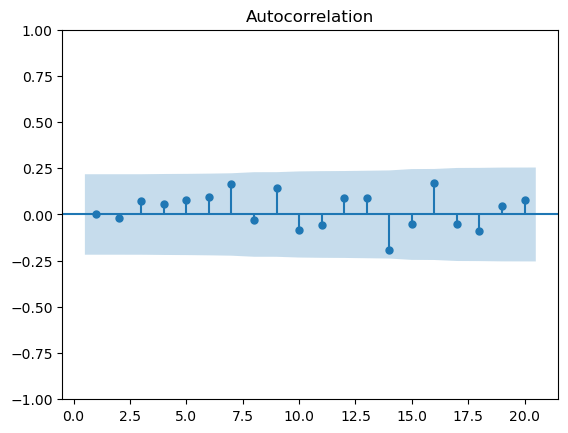

In [29]:
sgt.plot_acf(df_train.mod_ma6_resid[1:], zero=False);

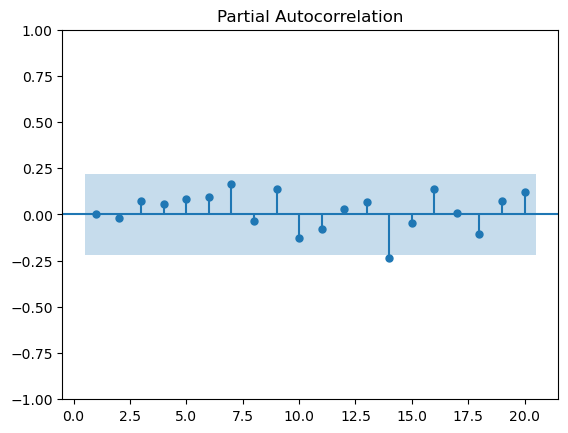

In [30]:
sgt.plot_pacf(df_train.mod_ma6_resid[1:], zero=False);

In [31]:
mod_ar1_ma1 = ARIMA(df_train.mkt_price, order=(1, 0, 1))
results_ar1_ma1 = mod_ar1_ma1.fit()
print(results_ar1_ma1.summary())

                               SARIMAX Results                                
Dep. Variable:              mkt_price   No. Observations:                   82
Model:                 ARIMA(1, 0, 1)   Log Likelihood                  58.253
Date:                Wed, 25 Sep 2024   AIC                           -108.506
Time:                        15:28:07   BIC                            -98.879
Sample:                    04-05-2024   HQIC                          -104.641
                         - 07-29-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.6377      0.166     27.980      0.000       4.313       4.963
ar.L1          0.9319      0.049     19.010      0.000       0.836       1.028
ma.L1          0.0306      0.128      0.240      0.8

In [32]:
mod_ar1_ma1 = ARIMA(df_train.returns, order=(1, 0, 1))
results_ar1_ma1 = mod_ar1_ma1.fit()
print(results_ar1_ma1.summary())

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                   82
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -190.416
Date:                Wed, 25 Sep 2024   AIC                            388.832
Time:                        15:28:07   BIC                            398.459
Sample:                    04-05-2024   HQIC                           392.697
                         - 07-29-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2639      0.285     -0.927      0.354      -0.822       0.294
ar.L1         -0.0365      3.109     -0.012      0.991      -6.131       6.058
ma.L1          0.0017      3.114      0.001      1.0

In [33]:
sts.adfuller(df_train.mod_ma6_resid)

(-10.88070345538527,
 1.2970392612077143e-19,
 0,
 81,
 {'1%': -3.5137900174243235,
  '5%': -2.8979433868293945,
  '10%': -2.5861907285474777},
 -96.36971937384001)

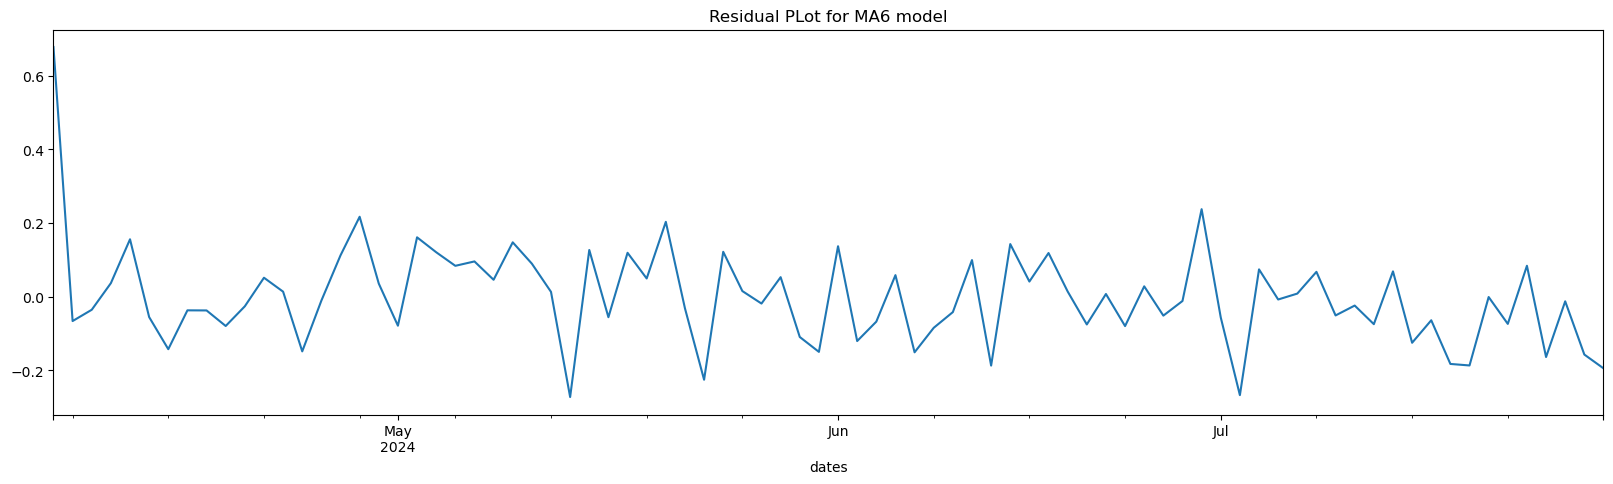

In [34]:
df_train.mod_ma6_resid.plot(figsize=(20, 5))
plt.title("Residual PLot for MA6 model");

In [35]:
df_train.mod_ma6_resid.mean(), df_train.mod_ma6_resid.var() 

(-0.0017453877763636259, 0.018216347326504664)

#### An ARIMA test on the series

In [36]:
model_prices_arima111 = pm.ARIMA(order=(1, 1, 1))
results_prices111  =  model_prices_arima111.fit(df_train.mkt_price)
print(results_prices111.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   82
Model:               SARIMAX(1, 1, 1)   Log Likelihood                  59.746
Date:                Wed, 25 Sep 2024   AIC                           -111.491
Time:                        15:28:08   BIC                           -101.913
Sample:                    04-05-2024   HQIC                          -107.648
                         - 07-29-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0011      0.001     -0.903      0.366      -0.003       0.001
ar.L1          0.8898      0.114      7.807      0.000       0.666       1.113
ma.L1         -1.0000    200.038     -0.005      0.9

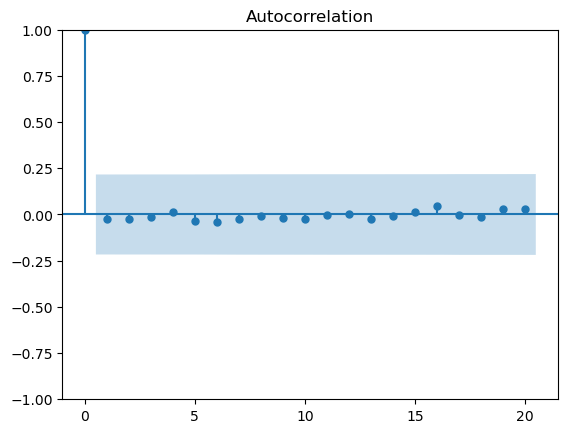

In [37]:
sgt.plot_acf(results_prices111.resid());

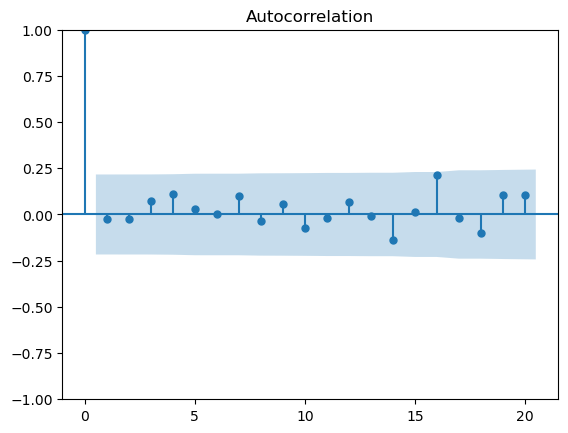

In [38]:
sgt.plot_acf(df_train.mod_ma6_resid);

In [39]:
df = output["copy"]

In [40]:
df["high"][:82]

dates
2024-04-05    5.3700
2024-04-08    5.1500
2024-04-09    5.1200
2024-04-10    5.0000
2024-04-11    5.0100
               ...  
2024-07-23    4.2200
2024-07-24    4.2450
2024-07-25    4.2800
2024-07-26    4.2993
2024-07-29    4.1900
Freq: B, Name: high, Length: 82, dtype: float64

In [41]:
df_train.mkt_price

dates
2024-04-05    5.2900
2024-04-08    5.1300
2024-04-09    5.0000
2024-04-10    4.9200
2024-04-11    4.9740
               ...  
2024-07-23    4.2200
2024-07-24    4.1584
2024-07-25    4.2800
2024-07-26    4.2245
2024-07-29    4.1550
Freq: B, Name: mkt_price, Length: 82, dtype: float64

##### A Max model on the series

In [42]:
mod_armax = ARIMA(df_train.mkt_price, order=(0, 0, 5), exog=df["high"][:82])
results_armax = mod_armax.fit(method_kwargs={"maxiter":1000})
print(results_armax.summary())

                               SARIMAX Results                                
Dep. Variable:              mkt_price   No. Observations:                   82
Model:                 ARIMA(0, 0, 5)   Log Likelihood                 133.920
Date:                Wed, 25 Sep 2024   AIC                           -251.839
Time:                        15:28:10   BIC                           -232.585
Sample:                    04-05-2024   HQIC                          -244.109
                         - 07-29-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0682      0.099      0.691      0.490      -0.125       0.262
high           0.9717      0.021     46.442      0.000       0.931       1.013
ma.L1         -0.0300      0.109     -0.275      0.7

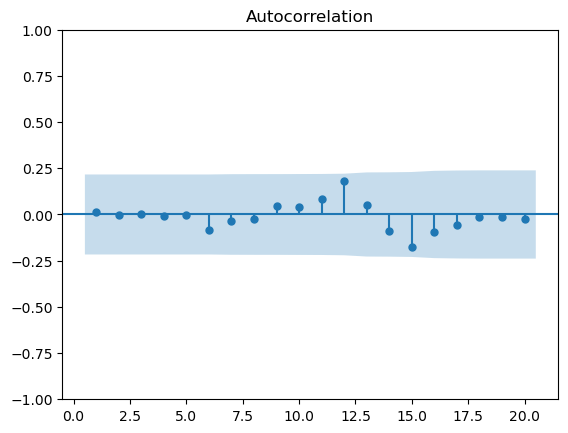

In [43]:
sgt.plot_acf(ARIMAResultsWrapper(results_armax).resid, zero=False);

In [44]:
df_train

,mkt_price,returns,mod_ma6_resid
dates,,,
2024-04-05,5.2900,NaN,0.678167
2024-04-08,5.1300,-3.024575,-0.065956
2024-04-09,5.0000,-2.534113,-0.035300
2024-04-10,4.9200,-1.600000,0.036970
2024-04-11,4.9740,1.097561,0.156079
...,...,...,...
2024-07-23,4.2200,2.676399,0.084164
2024-07-24,4.1584,-1.459716,-0.163637
2024-07-25,4.2800,2.924202,-0.012362


In [45]:
df_train["Volatility"] = df_train.returns**2

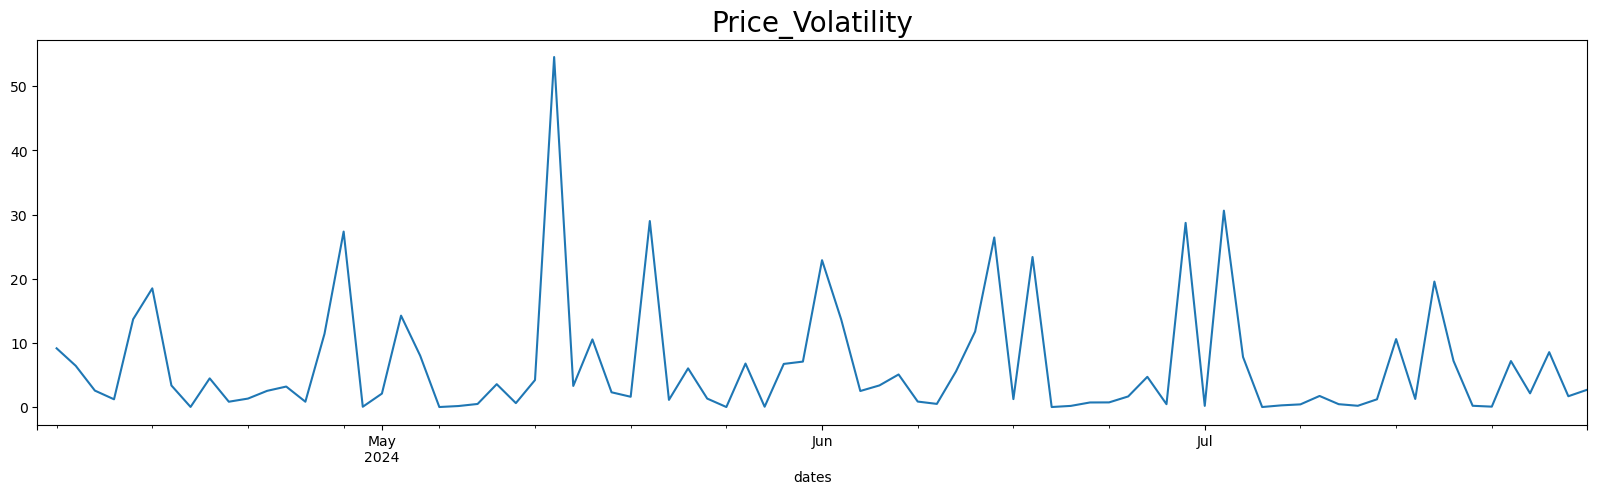

In [46]:
df_train.Volatility.plot(figsize=(20, 5))
plt.title("Price_Volatility", size = 20);

In [47]:
df_train

,mkt_price,returns,mod_ma6_resid,Volatility
dates,,,,
2024-04-05,5.2900,NaN,0.678167,NaN
2024-04-08,5.1300,-3.024575,-0.065956,9.148052
2024-04-09,5.0000,-2.534113,-0.035300,6.421729
2024-04-10,4.9200,-1.600000,0.036970,2.560000
2024-04-11,4.9740,1.097561,0.156079,1.204640
...,...,...,...,...
2024-07-23,4.2200,2.676399,0.084164,7.163112
2024-07-24,4.1584,-1.459716,-0.163637,2.130770
2024-07-25,4.2800,2.924202,-0.012362,8.550955


In [48]:
df_train.drop("Volatility", axis=1, inplace=True)

In [49]:
mod_arch1 = arch_model(df_train.returns[1:],  vol="ARCH", p=6)
results_arch1 = mod_arch1.fit()
print(results_arch1.summary())

Iteration:      1,   Func. Count:     10,   Neg. LLF: 196.96753524430918
Iteration:      2,   Func. Count:     21,   Neg. LLF: 190.43949415308828
Iteration:      3,   Func. Count:     30,   Neg. LLF: 190.56163758143617
Iteration:      4,   Func. Count:     40,   Neg. LLF: 190.49012349390526
Iteration:      5,   Func. Count:     50,   Neg. LLF: 190.4511241167293
Iteration:      6,   Func. Count:     60,   Neg. LLF: 190.38847438888743
Iteration:      7,   Func. Count:     69,   Neg. LLF: 190.38847394946976
Optimization terminated successfully    (Exit mode 0)
            Current function value: 190.38847394946976
            Iterations: 7
            Function evaluations: 69
            Gradient evaluations: 7
                      Constant Mean - ARCH Model Results                      
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-L

In [50]:
mod_auto = pm.arima.auto_arima(df_train.mkt_price)

In [51]:
mod_auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   82
Model:               SARIMAX(0, 1, 0)   Log Likelihood                  57.746
Date:                Wed, 25 Sep 2024   AIC                           -113.493
Time:                        15:28:12   BIC                           -111.098
Sample:                    04-05-2024   HQIC                          -112.532
                         - 07-29-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0141      0.002      6.895      0.000       0.010       0.018
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 0.65
Prob(Q):                              0.86   Prob(JB):                         0.72
Heteroskedasticity (H):               0.61   Skew:                             0.09
Prob(H) (two-sided):                  0.21   Kurtosis:                         3.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [52]:
mod_auto

ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [53]:
start_date = "2024-04-05"
end_date = "2024-07-29"

In [54]:
pred = results_ma6.predict(start=start_date, end=end_date)

In [55]:
pred

dates
2024-04-05    4.611833
2024-04-08    5.195956
2024-04-09    5.035300
2024-04-10    4.883030
2024-04-11    4.817921
                ...   
2024-07-23    4.135836
2024-07-24    4.322037
2024-07-25    4.292362
2024-07-26    4.381418
2024-07-29    4.349312
Freq: B, Name: predicted_mean, Length: 82, dtype: float64

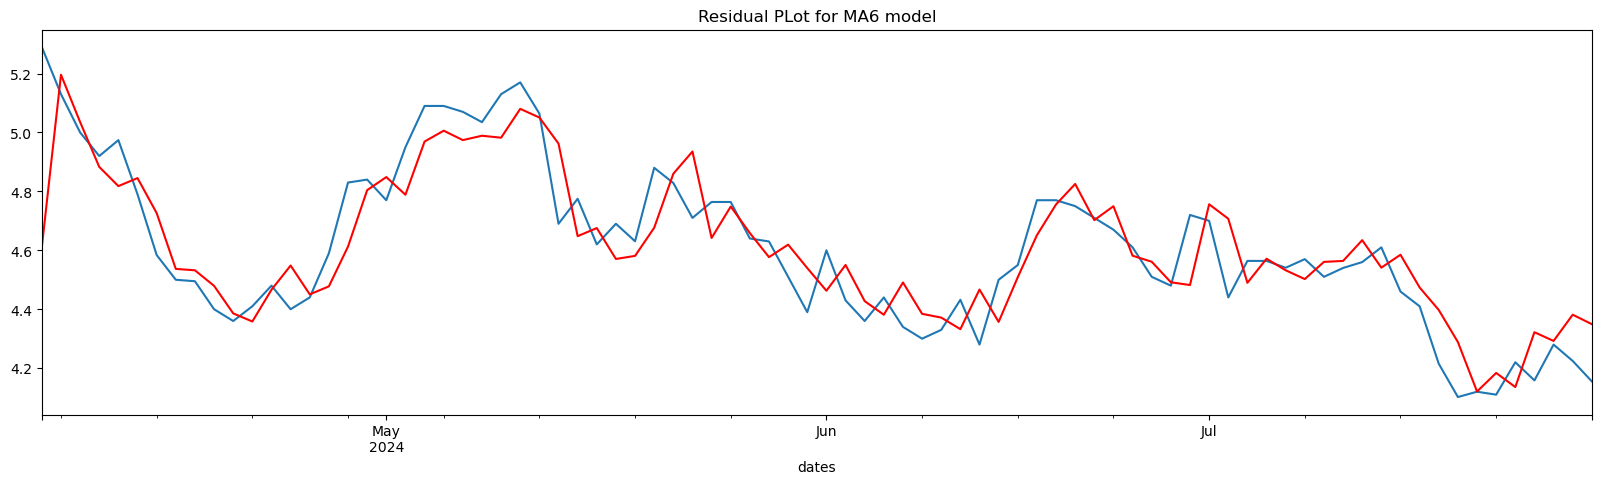

In [56]:
df_train["mkt_price"].plot(figsize=(20, 5))
pred.plot(color = "red")
plt.title("Residual PLot for MA6 model");

In [57]:
start = "2024-07-30"
end = "2024-08-27"
test_pred = results_ma6.predict(start=start, end=end)

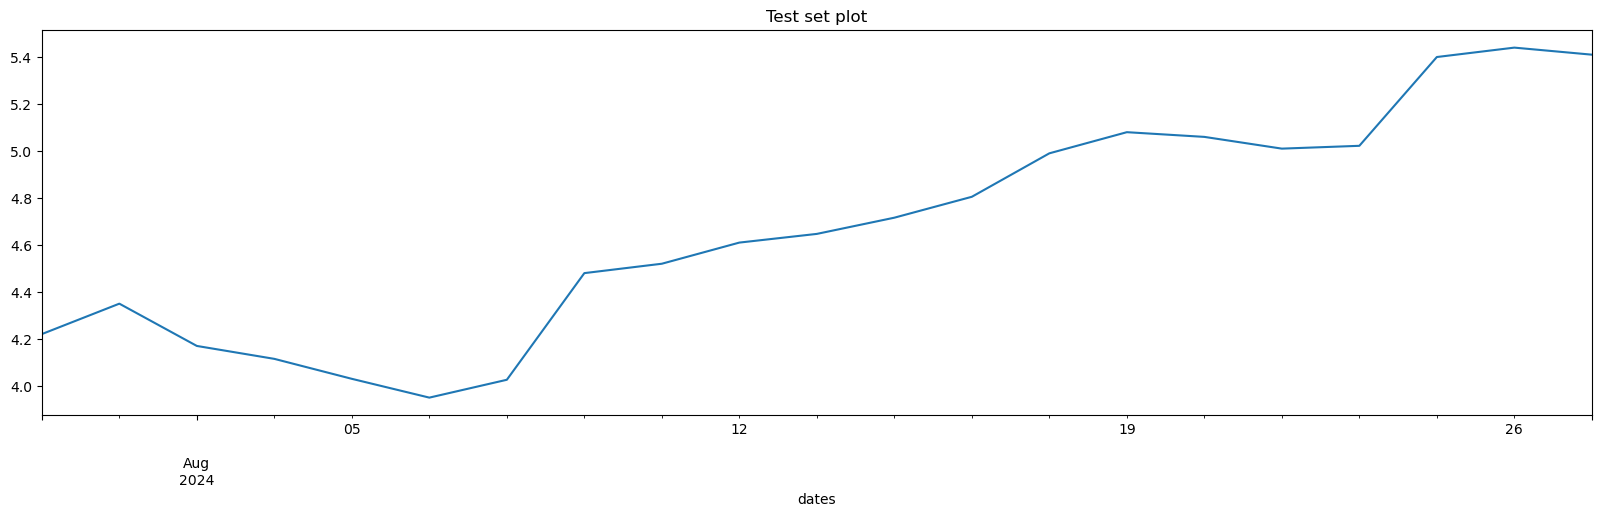

In [58]:
df_test = output["test"]


df_test["mkt_price"].plot(figsize=(20, 5))
#vals["Prediction"].plot()
plt.title("Test set plot");

In [59]:
df_test.head()

,mkt_price
dates,
2024-07-30,4.2205
2024-07-31,4.3500
2024-08-01,4.1700
2024-08-02,4.1150
2024-08-05,4.0300


In [60]:
df_test.tail()

,mkt_price
dates,
2024-08-21,5.010
2024-08-22,5.022
2024-08-23,5.400
2024-08-26,5.440
2024-08-27,5.410


In [61]:
train = list(df_train["mkt_price"])

In [62]:
test = list(df_test["mkt_price"])

In [63]:
len(train)

82

In [64]:
df["Date"] = df.index

In [65]:
df

,open,high,low,mkt_price,volume,Date
dates,,,,,,
2024-04-05,5.250,5.37,5.0900,5.290,598250.0,2024-04-05
2024-04-08,5.130,5.15,5.0900,5.130,88588.0,2024-04-08
2024-04-09,5.040,5.12,5.0000,5.000,36744.0,2024-04-09
2024-04-10,5.000,5.00,4.9200,4.920,36685.0,2024-04-10
2024-04-11,4.970,5.01,4.9000,4.974,28702.0,2024-04-11
...,...,...,...,...,...,...
2024-08-21,5.035,5.08,5.0050,5.010,3612.0,2024-08-21
2024-08-22,5.091,5.10,4.9800,5.022,9686.0,2024-08-22
2024-08-23,5.270,5.44,5.2400,5.400,9404.0,2024-08-23


In [66]:
str(df_test.index[0])

'2024-07-30 00:00:00'

In [67]:
df.index[0]

Timestamp('2024-04-05 00:00:00')

In [68]:
def walk_forward_validation(data):
    predictions = []
    X = data.shape[0]
    Y = int(X * 0.8)  # 80% for training
    
    # Loop through the remaining 20% of the data
    for i in range(0, X-Y, 1):
        # Use both 'Date' and 'Value' columns
        train_data = data.iloc[:Y+i]  # Incrementally add data to training set
        dates_train = train_data['Date']
        values_train = train_data['mkt_price']
        
        # Fit the ARIMA model
        mod_ma6 = ARIMA(values_train, order=(0, 0, 6))
        results_ma6 = mod_ma6.fit()
        
        # Make predictions
        pred = results_ma6.forecast(steps=1)
        predictions.append({
            'Prediction': pred[0], 
            'Train Start Date': dates_train.iloc[0],  # First date of the training set
            'Train End Date': dates_train.iloc[-1],  # Last date of the training set
            'Test Date': data['Date'].iloc[Y+i]  # Date for the prediction
        })
        
    return pd.DataFrame(predictions)


In [69]:
vals = walk_forward_validation(df)

C:\Users\kikio\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kikio\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kikio\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kikio\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\kikio\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximu

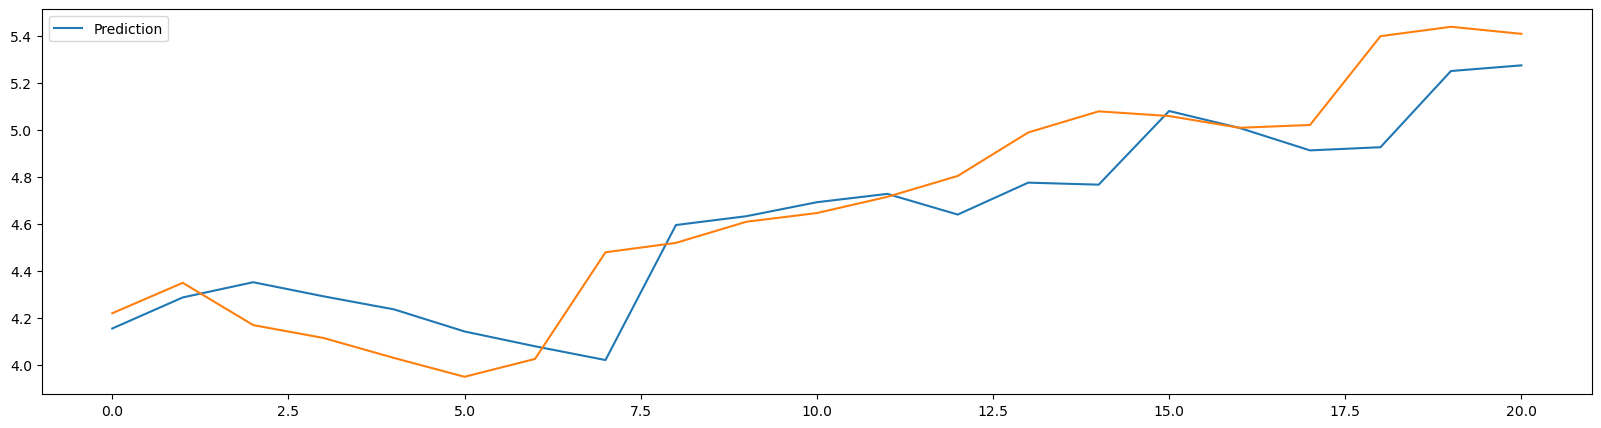

In [70]:
vals["Prediction"].plot(figsize=(20, 5))
plt.plot(test)
plt.legend();

In [71]:
with open("ts_model.pkl", "wb") as f:
    pickle.dump(results_ma6, f)